In [9]:
import numpy as np
import xarray as xr
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Activation, MaxPool2D, SeparableConv2D, AveragePooling2D, concatenate
from tensorflow.keras.models import Model, save_model, load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
%matplotlib inline

In [2]:
ds_path = "/scr/sci/mhayman/holodec/holodec-ml-data/"
#ds_name = "synthetic_holograms_v02_ft_ac_d_amplitude_float32.nc"
#ds_name = "synthetic_holograms_v02_ft_ac_d_real_imag_float32.nc"
ds_name = "synthethic_holograms_v0_ft_ac_d_amplitude_float32.nc"  # single particle histograms
ds = xr.open_dataset(ds_path+ds_name)  # file with mean (DC) value removed

In [36]:
#particle_labels = ds['particle_histogram'].stack(histogram_line=ds['particle_histogram'].dims[1:]).values
#all_labels = pd.DataFrame(particle_labels, index=ds['hologram_number'])

particle_labels_ft0 = np.fft.fft(particle_labels,axis=0)[:,:particle_labels.shape[1]//2]
particle_labels_ft = np.concatenate((np.real(particle_labels_ft0),np.imag(particle_labels_ft0)),axis=1)
particle_labels_ft.shape
all_labels = pd.DataFrame(particle_labels_ft, index=ds['hologram_number'])

In [37]:
split_index = 7000  # number of training+validation points
valid_index = 2000  # number of validation points
train_labels = all_labels.iloc[valid_index:split_index]
test_labels = all_labels.iloc[split_index:]
val_labels = all_labels.iloc[:valid_index]

scaler = MinMaxScaler()
scaled_train_labels = pd.DataFrame(scaler.fit_transform(train_labels), index=train_labels.index, columns=train_labels.columns)
scaled_test_labels = pd.DataFrame(scaler.transform(test_labels), index=test_labels.index, columns=test_labels.columns)
scaled_val_labels = pd.DataFrame(scaler.fit_transform(val_labels), index=val_labels.index, columns=val_labels.columns)

In [38]:
if not "channel" in ds["image_ft"].dims:
    in_data = ds["image_ft"].transpose("hologram_number", "xsize", 'ysize').expand_dims("channel", 3)
else:
    in_data = ds["image_ft"].transpose("hologram_number", "xsize", 'ysize',"channel")

In [6]:
in_data.dims

('hologram_number', 'xsize', 'ysize', 'channel')

In [7]:
ds["image_ft"].max()

<xarray.DataArray 'image_ft' ()>
array(2.313813)

In [7]:
scaled_in_data = in_data / 2.5

In [41]:
nn_descript = 'CombCNN_DenseNN'
filter_input = Input(shape=in_data.shape[1:])
pool_d1 = AveragePooling2D(pool_size=(8, 8))(filter_input)
dense_1 = Dense(32, activation="relu")(pool_d1)
dense_2 = Dense(32, activation="relu")(dense_1)
pool_d2 = MaxPool2D(pool_size=(2, 2))(dense_2)

conv_1 = SeparableConv2D(8, (5, 5), padding="same")(filter_input)
act_1 = Activation("relu")(conv_1)
pool_1 = MaxPool2D(pool_size=(4, 4))(act_1)
conv_2 = Conv2D(16, (5, 5), padding="same")(pool_1)
act_2 = Activation("relu")(conv_2)
pool_2 = MaxPool2D(pool_size=(4, 4))(act_2)



concat = concatenate([pool_d2,pool_2],axis=-1)
flat = flat = Flatten()(concat)
dense_3 = Dense(32, activation="relu")(flat)
out = Dense(all_labels.shape[1],activation='relu')(dense_3)  # number of outputs determined by the parameters we are training to
mod = Model(filter_input, out)
mod.compile(optimizer="adam", loss="mae",metrics=['acc'])
mod.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 600, 400, 2) 0                                            
__________________________________________________________________________________________________
separable_conv2d_9 (SeparableCo (None, 600, 400, 8)  74          input_11[0][0]                   
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 600, 400, 8)  0           separable_conv2d_9[0][0]         
__________________________________________________________________________________________________
average_pooling2d_10 (AveragePo (None, 75, 50, 2)    0           input_11[0][0]                   
____________________________________________________________________________________________

In [ ]:
plot_model(mod,show_shapes=True,to_file="results/holodec_"+nn_descript+'_'+ds_file.replace(".nc","")+"".join(all_labels.columns)+".png")

In [42]:
history = mod.fit(scaled_in_data[valid_index:split_index].values, scaled_train_labels.values, 
                  batch_size=16, epochs=30, verbose=1,
                  validation_data=(scaled_in_data[:valid_index].values,scaled_val_labels.values))

Train on 5000 samples, validate on 2000 samples
Epoch 1/30
5000/5000 [==============================] - 178s 36ms/sample - loss: 0.2190 - acc: 0.0602 - val_loss: 0.3010 - val_acc: 0.0000e+00
Epoch 2/30
5000/5000 [==============================] - 176s 35ms/sample - loss: 0.2105 - acc: 0.0728 - val_loss: 0.3171 - val_acc: 0.0785
Epoch 3/30
5000/5000 [==============================] - 176s 35ms/sample - loss: 0.2104 - acc: 0.0734 - val_loss: 0.3057 - val_acc: 0.0000e+00
Epoch 4/30
5000/5000 [==============================] - 172s 34ms/sample - loss: 0.2099 - acc: 0.0738 - val_loss: 0.3042 - val_acc: 0.0000e+00
Epoch 5/30
5000/5000 [==============================] - 172s 34ms/sample - loss: 0.2100 - acc: 0.0760 - val_loss: 0.3141 - val_acc: 0.0000e+00
Epoch 6/30
5000/5000 [==============================] - 172s 34ms/sample - loss: 0.2098 - acc: 0.0800 - val_loss: 0.3127 - val_acc: 0.0000e+00
Epoch 7/30
5000/5000 [==============================] - 173s 35ms/sample - loss: 0.2095 - acc: 0.0

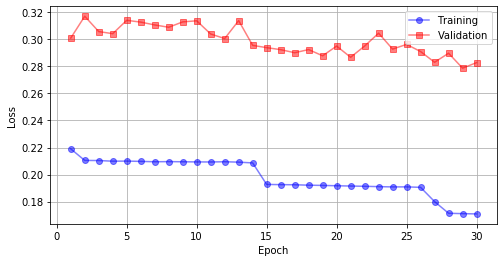

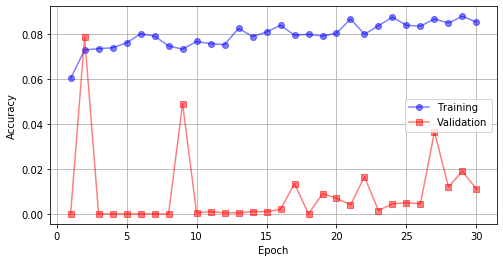

In [45]:
epochs = np.arange(len(history.history['acc']))+1
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(epochs,history.history['loss'],'bo-',alpha=0.5,label='Training')
ax.plot(epochs,history.history['val_loss'],'rs-',alpha=0.5,label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(b=True)
plt.legend()
plt.savefig("results/LossHistory_"+nn_descript+'_'+ds_name.replace(".nc","")+".png", dpi=200, bbox_inches="tight")

fig, bx = plt.subplots(1, 1, figsize=(8, 4))
bx.plot(epochs,history.history['acc'],'bo-',alpha=0.5,label='Training')
bx.plot(epochs,history.history['val_acc'],'rs-',alpha=0.5,label='Validation')
bx.set_xlabel('Epoch')
bx.set_ylabel('Accuracy')
bx.grid(b=True)
plt.legend()
plt.savefig("results/AccuracyHistory_"+nn_descript+'_'+ds_name.replace(".nc","")+".png", dpi=200, bbox_inches="tight")


In [ ]:
# can skip the training process and just load the CNN model
#mod = load_model("holodec_ft_cnn.h5")

In [47]:
cnn_start = datetime.datetime.now()
preds_out = mod.predict(scaled_in_data.values, batch_size=64)
cnn_stop = datetime.datetime.now()
print(f"{scaled_in_data.values.shape[0]} samples in {(cnn_stop-cnn_start).total_seconds()} seconds")
print(f"for {(cnn_stop-cnn_start).total_seconds()/scaled_in_data.values.shape[0]} seconds per hologram")

10000 samples in 85.743122 seconds
for 0.0085743122 seconds per hologram


In [51]:
save_model(mod, "results/holodec_"+nn_descript+'_'+ds_name.replace(".nc","")+".h5", save_format="h5")

In [48]:
preds_original = scaler.inverse_transform(preds_out)

In [ ]:
(test_labels.max() - test_labels.min())

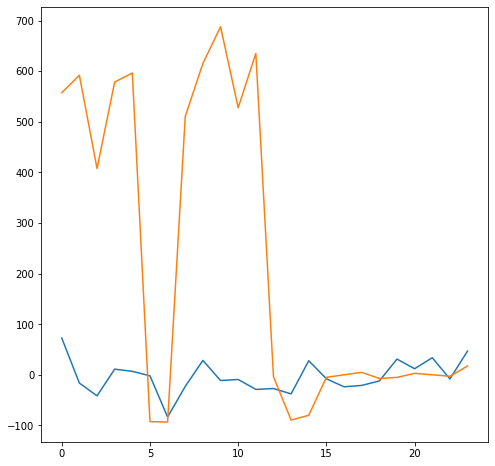

In [49]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
axes.plot(test_labels.iloc[10,:])
axes.plot(preds_original[10])

In [ ]:
preds_original[10]

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.scatter(test_labels, preds_original[split_index:], 1, 'k')
diag = np.linspace(test_labels.min(), test_labels.max(), 10)
axes.plot(diag, diag, 'b--' )
axes.set_title(test_labels.columns[0])
plt.savefig("results/error_hist_fft_"+nn_descript+'_'+ds_name.replace(".nc","")+".png", dpi=200, bbox_inches="tight")
# for a, ax in enumerate(axes.ravel()):
    

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.hist( (preds_original[split_index:] - test_labels.values)/ (test_labels.values.max() - test_labels.values.min()) ,
           bins=20)
axes.set_yscale("log")
axes.set_xlabel("Error in "+test_labels.columns[0])
plt.savefig("results/relative_error_histogram_fft.png", dpi=200, bbox_inches="tight")

In [ ]:
np.mean(np.abs(preds_original[split_index:] - test_labels.values), axis=0)

In [ ]:
np.mean(np.abs(preds_out[split_index:] - scaled_test_labels.values), axis=0)

In [ ]:
test_labels["d"].max()

In [ ]:
ds["xsize"]